In [1]:
import matplotlib.pyplot as plt

from validation.data import (
    load_from_jsonl,
)

from validation.analysis import (
    process_data,
    plot_classification_results,
    find_optimal_bounds_parallel,
    classify_data,
    plot_length_vs_distance_comparison,
)



DATA_PATHS = {
    "honest_qwen3_32": "../resources/Qwen3-32B-FP8-fp8___Qwen3-32B-FP8-fp8__alpaca_final_repro.jsonl",
    "fraud_qwen3_32": "../resources/Qwen3-32B-quantized.w4a16-int4___Qwen3-32B-FP8-fp8__alpaca_final.jsonl",
}

In [2]:
data_path_to_fit = {}
data_path_to_distances = {}

def plot_results(name, comparison):
    distances_honest = data_path_to_distances[comparison["honest"]]
    distances_fraud = data_path_to_distances[comparison["fraud"]]
    
    optimal_lower, optimal_upper = find_optimal_bounds_parallel(distances_honest, distances_fraud, n_jobs=64, step=0.001)
    
    classifications_full = classify_data(distances_honest, optimal_lower, optimal_upper)
    classifications_fraud = classify_data(distances_fraud, optimal_lower, optimal_upper)

    honest_items = load_from_jsonl(comparison["honest"])
    fraud_items = load_from_jsonl(comparison["fraud"])
    
    plot_classification_results(
        distances_honest, classifications_full, optimal_lower, optimal_upper, title_prefix="Classification results for honest inference (FP8 vs FP8, different machines)"
    )
    plot_classification_results(
        distances_fraud, classifications_fraud, optimal_lower, optimal_upper, title_prefix="Classification results for fraudulent inference (FP8 vs INT4, different machines)"
    )

    plot_length_vs_distance_comparison(name, honest_items, distances_honest, fraud_items, distances_fraud)

for name, data_path in DATA_PATHS.items():
    items = load_from_jsonl(data_path, n=100000)
    items, distances, top_k_matches_ratios = process_data(items)
    data_path_to_distances[data_path] = distances



Dropped 0 / 1000 items
Dropped 0 / 1000 items


In [3]:
comparisons = {
    "Qwen/Qwen3-32B-FP8":
     {
        "honest": DATA_PATHS["honest_qwen3_32"],
        "fraud": DATA_PATHS["fraud_qwen3_32"]
     }
}

# Introduction

Data to reproduce: https://drive.google.com/drive/folders/1ehpcVC0pGw0XwrchXZUxTTRy1KdhBxrz?usp=drive_link


## Qwen/Qwen3-32B-FP8

Servers for honest validation:
- 1xH100
- 4x3090


Searching optimal bounds: 100%|██████████| 91/91 [00:01<00:00, 62.94it/s]


Optimal Lower Bound: 0.041860
Best F1-Score: 0.9955


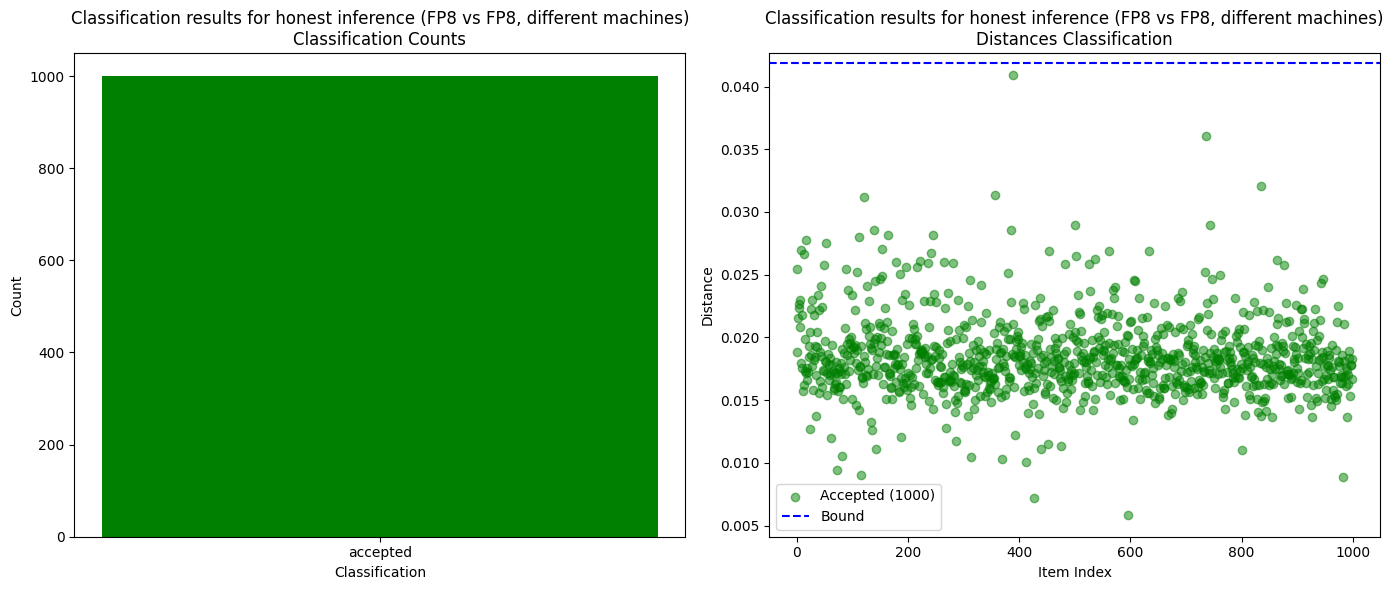

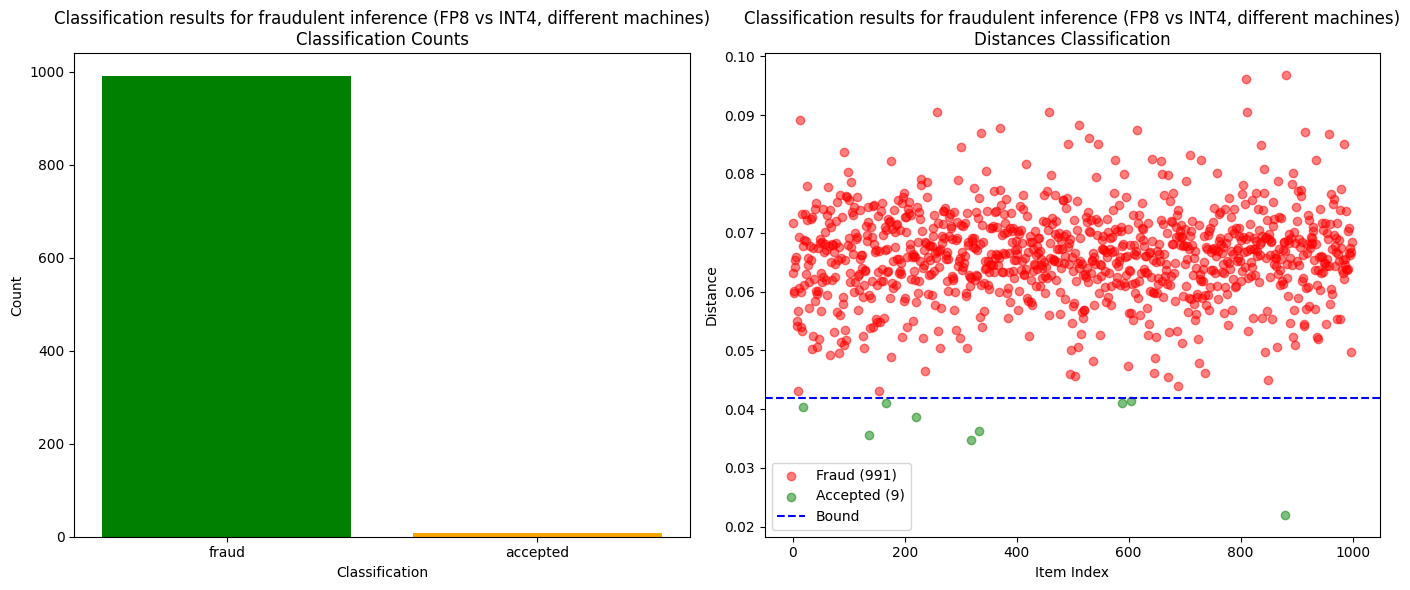

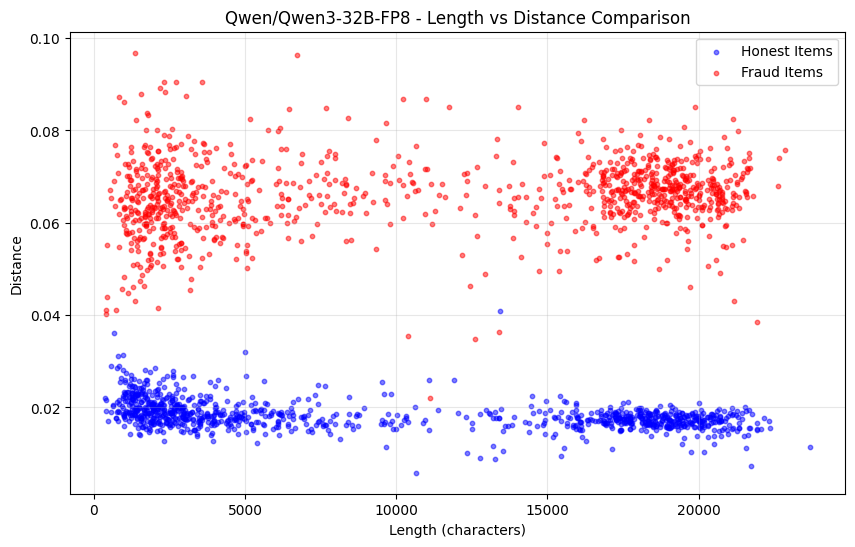

In [4]:
name = "Qwen/Qwen3-32B-FP8"
comparison = comparisons[name]
plot_results(name, comparison)

### Results

1. FP = 0 => all honest inferences are marked as honest
2. TN = 0.991

# Data Samples

In [5]:
items = load_from_jsonl(comparison["fraud"])
item = items[0]

## Inference 

For each genereated position we store logits for top-k tokems:

In [6]:
print(item.inference_result.text)
for idx, position in enumerate(item.inference_result.results[:10]):
    print(f"position {idx:4d}: {position.token}")
    for key, value in sorted(position.logprobs.items(), key=lambda x: x[1], reverse=True):
        print(f"   {key:4s}: {value:6.2f}")


<think>
Okay, I need to transcribe this audio file that's been provided as an example in my training data.

Let me first check if there is any actual content or information related to what needs to be transcribed from "the recording". However, based on just seeing these instructions without accompanying files, it appears no specific audio has been given directly here for transcription purposes yet within our conversation history either - making direct transcription impossible at present due to lack of necessary input material being accessible through current context alone.
</think>

To assist you effectively, please provide the following:

1. **The Audio File**: Share the recording (e.g., via upload link, URL, or embedded media).
2. **Context** (if needed): Specify language, speakers' details, background noise, etc.
3. **Format Preference**: Indicate preferred output format (plaintext, timestamps, speaker labels).

Without the recording itself, I cannot proceed with transcription. Let 

Same text if generated at validation and top-k logprobs recomputed:

In [7]:
print(item.validation_result.text)
for idx, position in enumerate(item.validation_result.results[:10]):
    print(f"position {idx:4d}: {position.token}")
    for key, value in sorted(position.logprobs.items(), key=lambda x: x[1], reverse=True):
        print(f"   {key:4s}: {value:6.2f}")


<think>
Okay, I need to transcribe this audio file that's been provided as an example in my training data.

Let me first check if there is any actual content or information related to what needs to be transcribed from "the recording". However, based on just seeing these instructions without accompanying files, it appears no specific audio has been given directly here for transcription purposes yet within our conversation history either - making direct transcription impossible at present due to lack of necessary input material being accessible through current context alone.
</think>

To assist you effectively, please provide the following:

1. **The Audio File**: Share the recording (e.g., via upload link, URL, or embedded media).
2. **Context** (if needed): Specify language, speakers' details, background noise, etc.
3. **Format Preference**: Indicate preferred output format (plaintext, timestamps, speaker labels).

Without the recording itself, I cannot proceed with transcription. Let 

Comparison by distance: 

- go https://github.com/gonka-ai/gonka/blob/aa85699ab203f8c7fa83eb1111a2647241c30fc4/decentralized-api/internal/validation/inference_validation.go#L721

In [8]:
from validation.utils import distance2

threshold = 0.041860

dist = distance2(item.inference_result, item.validation_result)[0]

if dist > threshold:
    print("Fraud")
else:
    print("Honest")

Fraud


-------

# Proposal

We propose to modify sampling in vLLM in the way that $sample(artifact_{i}) = token_{i+1}$ will be reproducible.

Goals: 
- to make sure that logrprobs are transformed using all needed transformaton for sampling type and transform to format which guarantees reproducibility between machines
- make sure top-k from this logprobs is in artifacts in the same format 
- make sure sampling is reproducible on-chain

Further code will show simplified toy example how it can work.


## Generation

In [ ]:

def transform_logits(logits, prev_generated_tokens_ids):
    """
    defined by models itself and request parameters, doesnt really matter
    """

def gen_step(prompt, prev_generated_tokens_ids, llm, sampler, top_k):
    input_ids: list[int] = prompt + prev_generated_tokens_ids
    # 1 x vocab_size
    logits = llm.model.forward(input_ids)[-1]
    logprobs_for_sample = transform_logits(logits)
    logprobs_for_sample_decimal = Decimal(logprobs_for_sample)
    next_token_id = sampler.sample(logprobs_for_sample_decimal)
    sorted_logprobs_ids = argsort(logprobs_for_sample_decimal)[:top_k]
    artifact = {
        token_id: logprobs_for_sample_decimal[token_id]
        for token_id in sorted_logprobs_ids
    }

    return next_token_id, artifact


# Inside vLLM
def generate(prompt, llm, run_seed, top_k) -> tuple[list[int], list[dict[int, Decimal]]]:
    RNG = RNG(run_seed)
    sampler = Sampler(RNG)
    generated_tokens = []
    artifacts = []
    while True:
        next_token_id, artifact = gen_step(prompt, generated_tokens, llm, sampler, top_k)
        generated_tokens.append(next_token_id)
        artifacts.append(artifact)
        if next_token_id == eos_token_id:
            break
    return generated_tokens, artifacts

## Validation 

Then, the additional validation to existing procedure which doesn't require GPU or inference:

In [ ]:
# Any unused token id to mark low probability token which is not in artifact but was sampled
# Sampler should be modified for sure, to guarantee that
another_token_id = -1

def validate_artifacts(
    generated_tokens: [int],
    artifacts: list[dict[int, Decimal]],
    run_seed: int,
):
    RNG = RNG(run_seed)
    sampler = Sampler(RNG)
    for generated_token, artifact in zip(generated_tokens, artifacts):
        if generated_token not in artifact:
            generated_token = another_token_id
        another_token_prob = Decimal(1) - sum(artifact.values())
        artifact_to_sample = {
            **artifact,
            another_token_id: another_token_prob,
        }
        next_token_id = sampler.sample(artifact_to_sample)
        assert next_token_id == generated_token
